In [1]:
# This line is a convenience to import most packages you'll need. You may need to import others (e.g. random and cmath)
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, cmath,math
from IPython.display import Audio
 
# This line makes sure your plots happen IN the webpage you're building, instead of in separate windows.
%matplotlib inline

In [2]:
from scipy.fftpack import fft
from scipy.signal import hann

def stft(signal, window_size, hop_size, window_type = 'hann'):
    """
    Computes the short term fourier transform of a 1-D numpy array, where the array 
    is windowed into a set of subarrays, each of length window_size. The distance between
    window centers (in samples) is given by hop_size. The type of window applied is
    determined by window_type. This returns a 2-D numpy array where the ith column
    is the FFT of the ith window. Each column contains an array of complex values.
    
    Input Parameters
    ----------------
    signal: The 1-d (complex or real) numpy array containing the signal
    window_size: an integer scalar specifying the number of samples in a window
    hop_size: an integer specifying the number of samples between the start of adjacent windows
    window_type: a string specifying one of two "hann" or "rectangular"
    
    Returns
    -------
    a 2D numpy array of complex numbers where the array column is the FFT of the ith window,
    and the jth element in the ith column is the jth frequency of analysis.
    """
    
    # figure out how many hops
    length_to_cover_with_hops = len(signal) - window_size;
    assert (length_to_cover_with_hops >= 0), "window_size cannot be longer than the signal to be windowed"
    num_hops = int(1 + np.floor(length_to_cover_with_hops/hop_size));
    
    # make our window function
    if (window_type == 'hann'):
        window = sp.signal.hann(window_size, sym=False)
    else:
        window = np.ones(window_size) # rectangular window
    
    stft = [0]*num_hops
    # fill the array with values 
    for hop in range(num_hops):
        start = hop*hop_size
        end = start + window_size
        unwindowed_sound = signal[start:end]
        windowed_sound =  unwindowed_sound * window
        stft[hop]= fft(windowed_sound, window_size) 
    return np.array(stft).T

In [3]:
from scipy.fftpack import ifft

def istft(X, hop_size):
    """
    Takes a 2-D numpy array representing an STFT of some signal, where stft[i,j] is the jth
    frequency of analysis in the FFT of the ith window. 
    Performs an inverse FFT on each window and then does overlap & add resynthesis to rebuild 
    the original signal the STFT was built from.
    
    Input Parameters
    ----------------
    X: a 2-D numpy array of complex numbers representing an STFT, where the ith 
    column is the FFT of the ith window, and the jth row is the jth frequency of analysis.
        
    hop_size: an integer specifying the number of samples between the start of adjacent windows.
        
    Returns
    -------
    a 1-d numpy array of (possibly complex) values representing the original signal used to make X
    """
    
    # make an empty signal of the appropriate length
    window_size,num_hops = X.shape
    signal_length = (num_hops-1)*hop_size + window_size 
    signal = np.zeros(signal_length,dtype='complex');
    
    #fill the signal
    for n in range(num_hops):
        start = n * hop_size
        end = start + window_size
        signal[start:end] = signal[start:end] + ifft(X[:,n])
    return signal

In [4]:
def plt_spectrogram(X,win_length, hop_size, sample_rate, zoom_x=None, zoom_y=None,tick_labels='time-freq'):
    """
    Plots the log magnitude spectrogram.
    
    Input Parameters:
    ------------------
    X: 2D complex numpy array containing the stft values. Rows correspond to frequency bins and columns to time frames.
    win_length: the length of the analysis window
    hop_size: the hop size between adjacent windows
    sample_rate: sampling frequency
    tick_labels: the type of x and y tick labels, there are two options:
                 'time-freq': shows times (sec) on the x-axis and frequency (Hz) on the y-axis (default)
                 'bin-frame': shows time frame numbers on the x-axis and frequency bin numbers on the y-axis
                
    zoom_x: 1 by 2 numpy array containing the range of values on the x-axis, e.g. zoom_t = np.array([x_start,x_end])
    zoom_y: 1 by 2 numpy array containing the range of values on the y-axis, e.g. zoom_f = np.array([y_start,y_end])
    
    
    Returns:
    ---------
    times: 1D real numpy array containing time instances corresponding to stft frames
    freqs: 1D real numpy array containing frequencies of analyasis up to Nyquist rate
    2D plot of the magnitude spectrogram
    """
    
    # Find the size of stft
    Nf,Nt = np.shape(X)
    
    # Compute the log magnitude spectrogram
    X = 20*np.log10(np.abs(X))

    # Extract the lower half of the spectrum for each time frame
    X = X[0:int(Nf/2)+1] # make sure to include both 0 and Nyquist frequency
    Nf = np.shape(X)[0]
        
    # Generate time vector for plotting
    times = (hop_size/float(sample_rate))*np.arange(Nt)
    
    # Generate frequency vector for plotting
    freqs = (float(sample_rate)/win_length)*np.arange(Nf)
    
    # Generate time and frequency matrices for pcolormesh
    times_matrix,freqs_matrix = np.meshgrid(times,freqs)
    
    # Plot the log magnitude spectrogram
    plt.title('Log magnitude spectrogram')
    if tick_labels == 'bin-frame':
        plt.pcolormesh(X)
        plt.xlabel('Time-frame Number')
        plt.ylabel('Frequency-bin Number')
    else:
        plt.pcolormesh(times_matrix,freqs_matrix,X)
        plt.xlabel('Time (sec)')
        plt.ylabel('Frequency (Hz)')

        
    # Zoom in on the plot if specified
    if zoom_x is None and zoom_y is None:
        plt.axis('tight')
        
    if zoom_x is not None:
        plt.xlim(zoom_x)
        
    if zoom_y is not None:
        plt.ylim(zoom_y)
        
    return    

(850,)


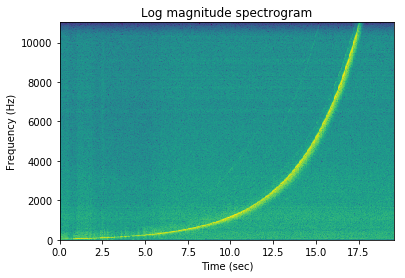

In [148]:
x,sr = librosa.load("sinesweep_recording.wav")
Audio(x,rate=sr)
pitches, magnitudes = librosa.piptrack(x,sr=sr)

final = np.max(pitches, axis=0)

stftX = stft(x, 2048, 1024, window_type = 'hann')

plt_spectrogram(stftX,2048, 1024, sr, zoom_x=None, zoom_y=None,tick_labels='time-freq')

xaxis = np.linspace(0,521,521)
print(np.shape(final))
#plt.scatter(xaxis,final)

(1025, 850)
(1025,)


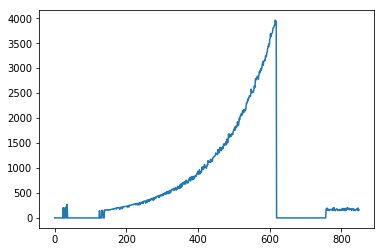

In [149]:

final = np.zeros(850)
print(np.shape(pitches))
xval = np.zeros(1)
yval = np.zeros(1)

transf = pitches.T


for ind, t in enumerate(transf):
    for ind2, f in enumerate(t):
        if f>0:
            final[ind] = f
            break

def getFundFreqs(pitchesArr):
    fundFreqArr = np.array([])
    transformedPitches = pitchesArr.T

    for ind, time in enumerate(transformedPitches):
        for ind2, freq in enumerate(time[:1000]):
            if freq>0:
                fundFreqArr = np.append(fundFreqArr,freq)
                break
    return fundFreqArr
            
            
print(np.shape(pitches[:,0]))
#plt.scatter(xval,yval)
plt.plot(final)
#plt.pcolor(pitches[:400,:])
            

In [1]:
#plt.plot(final)
plt.scatter(np.linspace(0,521,521),final)

NameError: name 'plt' is not defined

(850,)


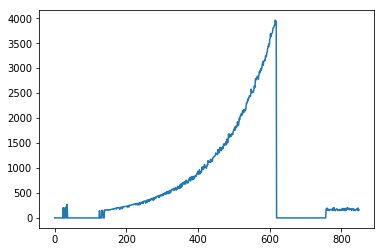

In [150]:
plt.plot(final)
print(np.shape(final))

In [23]:
def findNearestNote(freq,scale,midi):
    noteIndex = np.argmin(np.abs(scale-freq))
    return midi[noteIndex]

In [24]:
def getBaseFreq(freq):
    #multiplier = np.zeros(np.shape(freqArr)[0])
    #for i, freq in enumerate(freqArr):
    multiplier = 0
    while(freq>61.73541):
        #freqArr[i] = freqArr[i]/2
        freq = freq/2
        multiplier += 1
    return freq, multiplier

In [44]:
def getNotesInKeyOf(key):
    allNotes = np.zeros(12)
    allMIDINotes = np.zeros(12)

    allNotes[0] = 32.70320
    allNotes[1] = 34.64783
    allNotes[2] = 36.70810
    allNotes[3] = 38.89087
    allNotes[4] = 41.20344
    allNotes[5] = 43.65353
    allNotes[6] = 46.24930
    allNotes[7] = 48.99943
    allNotes[8] = 51.91309
    allNotes[9] = 55.0
    allNotes[10] = 58.27047
    allNotes[11] = 61.73541

    allMIDINotes[0] = 24
    allMIDINotes[1] = 25
    allMIDINotes[2] = 26
    allMIDINotes[3] = 27
    allMIDINotes[4] = 28
    allMIDINotes[5] = 29
    allMIDINotes[6] = 30
    allMIDINotes[7] = 31
    allMIDINotes[8] = 32
    allMIDINotes[9] = 33
    allMIDINotes[10] = 34
    allMIDINotes[11] = 35
    
    if key == "chromatic":
        return allNotes, allMIDINotes
    
    output = np.zeros(7)
    output[0] = allNotes[0]
    output[1] = allNotes[2]
    output[2] = allNotes[4]
    output[3] = allNotes[5]
    output[4] = allNotes[7]
    output[5] = allNotes[9]
    output[6] = allNotes[11]

    midi_output = np.zeros(7)
    midi_output[0] = allMIDINotes[0]
    midi_output[1] = allMIDINotes[2]
    midi_output[2] = allMIDINotes[4]
    midi_output[3] = allMIDINotes[5]
    midi_output[4] = allMIDINotes[7]
    midi_output[5] = allMIDINotes[9]
    midi_output[6] = allMIDINotes[11]
    
    notesArr = np.array([0,2,4,5,7,9,11])
    
    keyDict = {
        "c" : 0,
        "g" : 1,
        "d" : 2,
        "a" : 3,
        "e" : 4,
        "b" : 5,
        "f sharp" : 6,
        "f" : -1,
        "b flat" : -2,
        "e flat" : -3,
        "a flat" : -4,
        "d flat" : -5
    }
    
    accidentals = keyDict[key]
    if accidentals >= 0:
        if accidentals > 0:
            notesArr[3] += 1
        if accidentals > 1:
            notesArr[0] += 1
        if accidentals > 2:
            notesArr[4] += 1
        if accidentals > 3:
            notesArr[1] += 1
        if accidentals > 3:
            notesArr[5] += 1
        if accidentals > 4:
            notesArr[2] += 1
    if accidentals < 0:
        if accidentals < 0:
            notesArr[6] -= 1
        if accidentals < -1:
            notesArr[2] -= 1
        if accidentals < -2:
            notesArres[5] -= 1
        if accidentals < -3:
            notesArr[1] -= 1
        if accidentals < -4:
            notesArr[4] -= 1
        
    for i, note in enumerate(notesArr):
        output[i] = allNotes[note]
        midi_output[i] = allMIDINotes[note]
        
    
    return output, midi_output

In [40]:
def quantizeNotes(inputArr, key):
    scale, midi = getNotesInKeyOf(key)
    quantizedArr = np.zeros(np.shape(inputArr)[0])
    for i,sample in enumerate(inputArr):
        lowNote, octave = getBaseFreq(sample)
        note = findNearestNote(lowNote, scale, midi)
        quantizedArr[i] = note + (12*octave)
    return quantizedArr

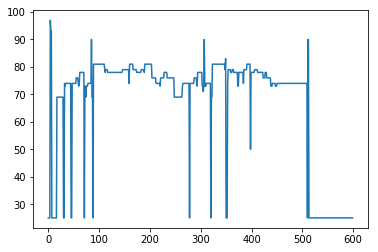

In [78]:
quantizedD = quantizeNotes(final,"d")

plt.plot(quantizedD[:600])

850
[24. 70. 70. 70. 70. 70. 70. 93. 93. 93.]


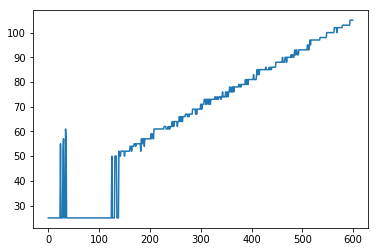

In [205]:

#quantized = quantizeNotes(final,"c")
quantizedD = quantizeNotes(final,"d")

lastNote = 70

print(np.size(quantizedD))
def clean_input(unclean):
    lastNote = 70
    for i,currNote in enumerate(unclean):
        if i<(np.size(unclean)-1) and lastNote != currNote and currNote != unclean[i+1]:
            isMinNoteLen = True
        else:
            isMinNoteLen = False
        if currNote<26 or currNote > 90 or isMinNoteLen:
            unclean[i]=lastNote
        else:
            lastNote=currNote
    return unclean

#quantizedD[0] = 24
plt.plot(quantizedD[:600])
print(quantized[:10])

[25. 25. 25. 25. 97. 93. 93. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 69.
 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 69. 25. 25. 74. 73. 74. 74.
 74. 74. 74. 74. 74. 74. 74. 74. 74. 25. 25. 74. 74. 74.]


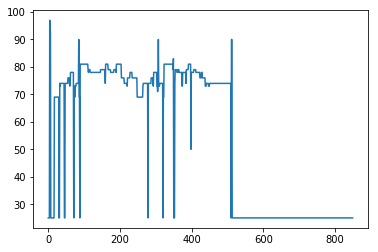

In [172]:
x,sr = librosa.load("sinesweep_recording.wav")
onsets = librosa.onset.onset_detect(x,sr=sr)
print(quantizedD[:50])
onsetArr = np.zeros(np.size(quantizedD))
onsetArr = onsetArr+65
for i,num in enumerate(onsets):
    onsetArr[num] = quantizedD[num]

plt.subplot()
plt.plot(quantizedD)
#plt.plot(onsetArr[:200])

In [106]:
def offset (audio, sr, bpm,length):
    '''
    Returns the offset times already modified for MIDI time
    '''
    hop_size = 512 # int((sr*60)/(bpm*24))
    window_size = hop_size*2
    window = sp.signal.windows.hann(window_size, sym=False)
    threshold = .0002

    offset_list = []

    length_to_cover_with_hops = len(audio) - window_size
    assert (length_to_cover_with_hops >= 0), "window_size cannot be longer than the signal to be windowed"
    #num_hops = int(1 + np.floor(length_to_cover_with_hops/hop_size))
    num_hops = length
    last_offset = -1
    #print(num_hops)
    for hop in range(num_hops-1):
        start = hop*hop_size
        end = start + window_size
        #print(start)
        #print(end)
        unwindowed_sound = audio[start:end]
        windowed_sound =  unwindowed_sound * window
        if np.sqrt(np.mean(windowed_sound**2)) < threshold:
            #print(np.sqrt(np.mean(windowed_sound**2)))
            #print(hop)
            if last_offset is not (hop - 1):
                offset_list.append(hop)
                last_offset = hop
            else:
                last_offset = hop
    return offset_list

In [108]:
offsets = (x,sr,120,850)
print(offsets)

(array([-0.00166012, -0.002572  , -0.0022486 , ...,  0.00013793,
        0.00017703,  0.        ], dtype=float32), 22050, 120, 850)


In [199]:
def p_track(audio,sr,bpm,key):
    '''
    returns pitches as well as times in which the pitch changes
    '''
    #bpm = 130
    hl = int((sr*60)/(bpm*24))
    raw_pitches, magnitudes = librosa.piptrack(audio,sr,hop_length=256)#hl)
    #print(raw_pitches)
    melody = getFundFreqs(raw_pitches)
    unclean = quantizeNotes(melody,key)
    pitches = clean_input(unclean)
    #pitches = unclean
    #print(pitches)
    pitch_change = []
    for pitch in range(len(pitches)):
        if pitch != 0:
            if pitches[pitch] != pitches[pitch-1]:
                pitch_change.append(pitch)
    return pitches, pitch_change

In [204]:
#x,sr = librosa.load("MIR-QBSH-corpus\waveFile\year6\person00004\00014.wav")
x,sr = librosa.load("trumpet.wav")

a,b = p_track(x,sr,120,"d")
#plt.plot(a)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

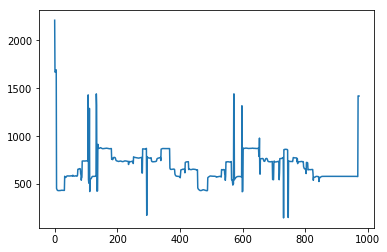

In [198]:
foo,_ = librosa.piptrack(x,sr,hop_length=256)
test = getFundFreqs(foo)
#test = np.max(foo,axis=0)
plt.plot(test)

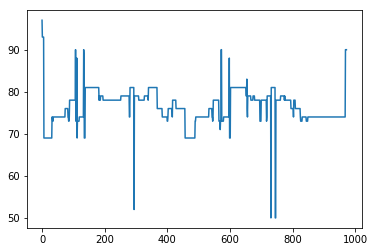

In [203]:
test2 = quantizeNotes(test,"d")
plt.plot(test2)

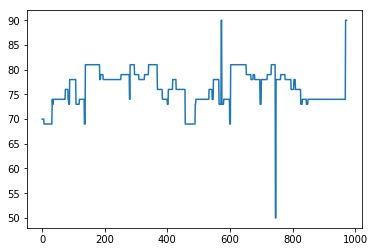

In [206]:
test3 = clean_input(test2)
plt.plot(test3)

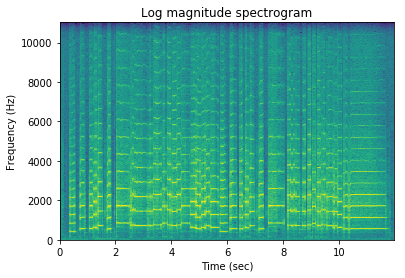

In [201]:
stftX = stft(x, 2048, 1024, window_type = 'hann')
pipTest,_ = librosa.piptrack(x,sr)

plt_spectrogram(stftX,2048, 1024, sr, zoom_x=None, zoom_y=None,tick_labels='time-freq')

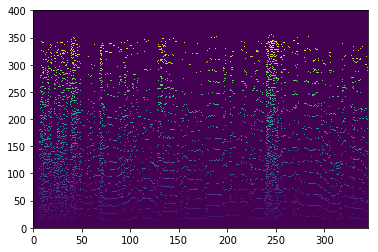

In [178]:
plt.pcolormesh(pipTest[:400,:])